## Transformer와 비교해 변경이 필요한 부분 


1. 데이타 전처리 
   - A안.  Input은 Question과 Answer를 붙인다. 
   - B안.  Input/ouput은 START와 END_TOKEN을 붙인다

2. Positional Embedding
   - Embedding Layer를 추가한다. 
   - 단어 임베딩과 별도로 inputs에 대한 positional embeding을 추가한다. 
   
3. Encoder 
   - Encoder는 삭제한다. 
   
4. Decorder 층
  - Decoder층은 Encoder가 없으므로, Encoder-Decoder Mutlti-head Attention Layer가 없음
    따라서 padding_mask도 필요 없음
  - Decoder 층 
      - Masked Multi-head Attention 층
      - Layer Norm
      - Feed Forward 
      - Layer Norm

5. 모델 구성 
  - gtp 모델은 [inputs, look_ahead_mask]와 [outputs]로 구성

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

## 데이타 전처리

In [2]:
import pandas as pd

# CSV 로딩
data_path = os.path.join(os.getenv("HOME"), "aiffel/transformer_chatbot/data/ChatbotData .csv")
df = pd.read_csv(data_path)

print(df.head())


                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [3]:
# 전처리 함수
def preprocess_sentence(sentence):

  # 소문자화 & 공백 제거 (한국어는 대소문자 의미 없음, 하지만 영어 혼합 대비)
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 앞뒤로 공백추가
 
  # 허용된 문자 외 제거 (한글, 영어, 숫자, 구두점)
  sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)
  
  # 다중 공백 정리
  sentence = re.sub(r'[" "]+', " ", sentence)        # 여러개의 공백을 하나로
  
  return sentence

In [4]:
# 질문과 답변 분리 + 전처리 적용
questions = [preprocess_sentence(q) for q in df['Q']]
answers = [preprocess_sentence(a) for a in df['A']]

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

print("전처리 후의 질문:", questions[:5])
print("전처리 후의 답변:", answers[:5])


전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 질문: ['12시 땡 ! ', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
전처리 후의 답변: ['하루가 또 가네요 . ', '위로해 드립니다 . ', '여행은 언제나 좋죠 . ', '여행은 언제나 좋죠 . ', '눈살이 찌푸려지죠 . ']


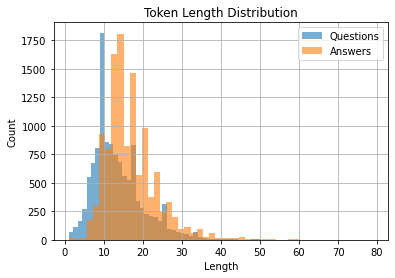

In [5]:
# 길이 확인을 위한 리스트 생성
question_lengths = [len(q) for q in questions]
answer_lengths = [len(a) for a in answers]

# 히스토그램 시각화
plt.hist(question_lengths, bins=50, alpha=0.6, label='Questions')
plt.hist(answer_lengths, bins=50, alpha=0.6, label='Answers')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.legend()
plt.grid()
plt.show()

**Subword Tokenizer**

1) TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  
    단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.

2) 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.

3) 최대 길이 MAX_LENGTH 인 MAX_LENGTH을 넘는 문장들은 필터링한다.

4) MAX_LENGTH보다 길이가 짧은 문장들은 MAX_LENGTH에 맞도록 패딩 한다.

In [6]:
import tensorflow_datasets as tfds


# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# 인자 : corpus = 문자열 리스트, target_vocab_size = 원하는 어휘 수
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [7]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
DEL_TOKEN = [tokenizer.vocab_size + 2]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('DEL_TOKEN의 번호 :' ,[tokenizer.vocab_size + 2])

# 시작 토큰과 종료 토큰을 고려하여 +3를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 3
print('단어장의 크기 :',(VOCAB_SIZE))

START_TOKEN의 번호 : [8168]
END_TOKEN의 번호 : [8169]
DEL_TOKEN의 번호 : [8170]
단어장의 크기 : 8171


**INPUT 및 LABEL 정의**

  - input은 질문과 대답으로 한 문장으로 계산  

In [8]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_full_input(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    input_ids = START_TOKEN + tokenizer.encode(sentence1) + DEL_TOKEN
    output_ids = tokenizer.encode(sentence2)+ END_TOKEN
    
    # 전체 input = 질문 + 대답
    full_input = input_ids + output_ids 
    
    # label은 padding 등을 고려해 필요 부분만 마스킹하도록 구성 (보통 output_ids에 해당)
    labels = [-100] * len(input_ids) + output_ids  # input 부분은 loss 계산에서 제외

    tokenized_inputs.append(full_input)
    tokenized_outputs.append(labels)

  return tokenized_inputs, tokenized_outputs


In [9]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    input_ids = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    output_ids = START_TOKEN+ tokenizer.encode(sentence2)+ END_TOKEN

    tokenized_inputs.append(input_ids)
    tokenized_outputs.append(output_ids)

  return tokenized_inputs, tokenized_outputs

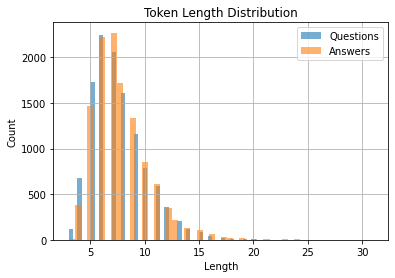

In [10]:
# 실제 질문과 답변 토큰화 수행
tokenized_questions, tokenized_answers = tokenize(questions, answers)


# 길이 확인을 위한 리스트 생성
question_lengths = [len(q) for q in tokenized_questions]
answer_lengths = [len(a) for a in tokenized_answers]

# 히스토그램 시각화
plt.hist(question_lengths, bins=50, alpha=0.6, label='Questions')
plt.hist(answer_lengths, bins=50, alpha=0.6, label='Answers')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.legend()
plt.grid()
plt.show()

In [11]:
# 질문과 답변의 최대 길이 출력
print('질문 최대 길이:', np.max(question_lengths))
print('답변 최대 길이:', np.max(answer_lengths))

# 98% 백분위수 기준 길이 출력
print('98% 질문 길이:', np.percentile(question_lengths, 98))
print('98% 답변 길이:', np.percentile(answer_lengths, 98))

질문 최대 길이: 23
답변 최대 길이: 31
98% 질문 길이: 14.0
98% 답변 길이: 15.0


In [12]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30

In [13]:
def filter_and_padding(tokenized_questions, tokenized_answers):

    filtered_inputs, filtered_outputs = [], []

    for q, a in zip(tokenized_questions, tokenized_answers):
        if len(q) <= MAX_LENGTH and len(a) <= MAX_LENGTH:
            filtered_inputs.append(q)
            filtered_outputs.append(a)

    # 패딩 적용
    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        filtered_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    padded_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        filtered_outputs, maxlen=MAX_LENGTH, padding='post'
    )

    return padded_inputs, padded_outputs

In [14]:
questions, answers = filter_and_padding(tokenized_questions, tokenized_answers)
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


**교사 강요(Teacher Forcing)는 사용하지 않는다**

In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        
        
    },
    {
        'outputs': answers,      # 디코더 출력 (정답), START_TOKEN 제거
    },
))

dataset = dataset.cache()                       # 메모리에 캐싱, 에포크가 반복될때 디스크 읽기/파싱 비용을 줄임
dataset = dataset.shuffle(BUFFER_SIZE)          # 무작위로 섞지 않으면, 학습이 데이터 순서에 의존하게 되어 과적합 위험이 높아짐
dataset = dataset.batch(BATCH_SIZE)             # 배치로 묶어서 모델에 한번에 전달
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # GPU가 학습하는 동안 CPU가 다음 배치를 미리 준비


## 공통 함수

**포지셔널 임베딩**

- PositinalEncoding은 사인,코사인이 교차되도록 포지션을 계산하지만 
- PositionalEmbedding은 Embedding Layer를 추가한다. 

In [16]:
from tensorflow.keras import layers

# 포지셔널 임베딩 레이어
# d_model : 임베딩 벡터의 차원,  각 단어 벡터의 차원 (예: 512)
# position: 입력 문장에서의 임베딩 벡터의 위치, 시퀀스의 최대 길이 
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, max_seq_len, embedding_dim):                                                           
    super(PositionalEmbedding, self).__init__()
    self.max_seq_len = max_seq_len
    self.embedding_dim = embedding_dim
    self.pos_embedding = tf.keras.layers.Embedding(
                        input_dim = max_seq_len,
                        output_dim = embedding_dim)
    
  def call(self, inputs):
    # inputs : (batch_size, seq_len, d_model)
    # self.pos_encoding : (1, max_position, d_model)
    # inputs의 seq_len <= max_position
    
    seq_len = tf.shape(inputs)[1]
    positions = tf.range(start=0, limit=seq_len, delta=1)
    positions = tf.expand_dims(positions, 0)  # [1, seq_len]
    positions = tf.tile(positions, [tf.shape(inputs)[0], 1])  # [batch_size, seq_len]
    return self.pos_embedding(positions)  # [batch_size, seq_len, embedding_dim]



**어텐션**

In [17]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트

  matmul_qk = tf.matmul(query, key, transpose_b=True)  # 행렬 곱셈(matrix multiplication), key를 transpose함
  # Q: (batch_size, num_heads, seq_len_q, depth)
  # K: (batch_size, num_heads, seq_len_k, depth)
  # transpose : 마지막 2개 차원에 바뀜 
  # K^T : (batch_size, num_heads, depth, seq_len_k)
  # QK^T → shape: (batch_size, num_heads, seq_len_q, seq_len_k)

  # 가중치를 정규화
  # Q,K이 차원이 depth이고, depth가 커질수록 내적값도 커지므로, depth를 사용해서 scale을 줄여준다. 
  depth = tf.cast(tf.shape(key)[-1], tf.float32)       # key 마지막 차원의 크기를 float32로 변환 (부동소수점자료형)
  logits = matmul_qk / tf.math.sqrt(depth)             # 차원수로 scaling하는 작업

  # 패딩에 마스크 추가
  # 마스크된 곳에는 아주 큰 마이너스 값으로 변경하여, 사용되지 않게.
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)
    
  

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  # (seq_len_q, seq_len_k) @ (seq_len_k, depth) → (seq_len_q, depth)
  # attention_logits  :  (batch_size, num_heads, seq_len_q, seq_len_k)
  # V                 :  (batch_size, num_heads, seq_len_k, depth)
  # output            :  (batch_size, num_heads, seq_len_q, depth)
  return output



In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    # d_model -> num_heads * depth 
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # -1: 자동으로 그 크기를 맞춰라 (seq_len)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])                  # (batch_size, num_heads, seq_len, depth)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    
    # inputs.shape = [batch_size, seq_len, embedding_dim]
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    # (batch_size, seq_len, embedding_dim)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    # (batch_size, num_heads, seq_len, projection_dim(depth))
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    # shape : (batch_size, num_heads, seq_len_q, projection_dim)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # concat을 하려고 shape를 바꿈 : (batch_size, seq_len_q, num_heads, projection_dim(depth))

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다 (num_heads * depth -> d_model)
    # (batch_size, seq_len, embedding_dim)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


**패딩 마스크**

In [19]:
#모델이 의미 없는 패딩 토큰에 주의를 빼앗기지 않도록 하기 위해 **마스킹(masking)**을 한다.
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)   # [7, 6, 0, 0, 0] → [False, False, True, True, True]
                                                    # Boolen 값을 float32로 변경 → [0.0, 0.0, 1.0, 1.0, 1.0]
  # (batch_size, 1, 1, sequence length_k)
  return mask[:, tf.newaxis, tf.newaxis, :]         # 차원을 확장해서, 어덴션 스코어와 잘 계산되게 맞추어줌

**룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**

In [20]:
def create_look_ahead_mask(x):
  # (batch_size, seq_len, dim)
  seq_len = tf.shape(x)[1]
  
  # tf.ones((seq_len, seq_len)) : (seq_len, seq_len)인 모든 원소가 1인 텐서
    #  [[1, 1, 1],
    #   [1, 1, 1],
    #   [1, 1, 1]]
  # tf.linalg.band_part ( input, num_lower, num_upper) : 행렬의 밴드부분만 남기고 나머지는 0으로 
  # 하삼각 행렬(lower triangular matrix)을 생성
    #  [[1, 0, 0],
    #   [1, 1, 0],
    #   [1, 1, 1]]
  # mask = 1 - 하삼각 행렬  (자신보다 뒤에 있는 토큰에 1을 설정하는 마스크 )
    #  [[0, 1, 1],
    #   [0, 0, 1],
    #   [0, 0, 0]]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
 
    
  padding_mask = create_padding_mask(x)
  # (batch_size, 1, 1, sequence length_k)

  return tf.maximum(look_ahead_mask, padding_mask) # 내자신 이후도 보지 말고, 패딩도 보지 말라
  # tf.maximum (a, b) : a, b는 같은 shape이거나, 브로드캐스트가 가능한 shape

## 디코더

**디코더층**

  - Masked Multi-head Attention 층
  - Layer Norm
  - Feed Forward 
  - Layer Norm 

In [21]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
  # units : FFN의 내부 유닛 수
  # d_model : 임베딩 차원
  # num_heads : 멀티헤드 어센션의 헤드 개수
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")    
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  # look_ahead_mask.shape = (batch_size, 1, seq_len_q, seq_len_k)
  # batch_size는 Keras Input에서 None으로 자동 처리
  # 1 → num_heads 차원에 broadcasting 가능
  # 모든 헤드에 동일한 마스크를 적용하면서도 시퀀스 길이에 따라 다르게 작동
  # shape=(1, None, None)은 멀티헤드 어텐션에 자연스럽게 마스크를 덧붙일 수 있게 하기 위한 브로드캐스트 설계


  # 1. 마스크드 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 2. LayerNormalization
  normal = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

  # 3 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(normal)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 4. 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + normal)


  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)


**디코더**

In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  # 스케일을 키운다 -> 벡터의 값을 약간 더 강하게 만들기 위한 정규화 효과 
  # 1) 초기 어덴션 스코어가 너무 작아지지 않도록 : 임베딩 값이 작으면 → QKᵀ의 값도 작아짐 → Softmax가 평평해지고, 학습이 느려짐
  # 2) 어텐션 연산에서 Q, K, V의 스케일과 맞춰주기 위함 : 어텐션에서는 QKᵀ / √d_k로 나누니까, 임베딩은 * √d_model로 곱해 균형을 맞춤
    
  # 포지셔널 임베딩
  pos_embeddings = PositionalEmbedding(MAX_LENGTH, d_model)(inputs)

  embeddings += pos_embeddings

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  #outputs = tf.keras.layers.Dense(vocab_size, activation='softmax', name='outputs')(outputs)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)


**Custom Learning rate Scheduling**

In [31]:
# 초기엔 학습률을 점점 올리고, 그 후엔 학습률을 점점 낮추는 방식
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=100):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps                    # warmup_steps: 학습률을 올리는 단계 수

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

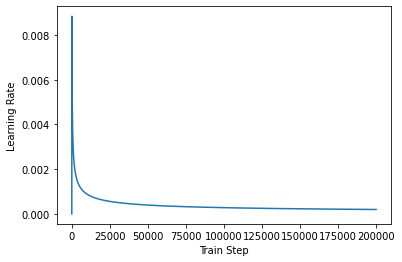

In [32]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 정의 및 학습하기

- decoder의 inputs과 outputs로 모델 정의

In [33]:
def gpt(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  #dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


**손실함수**

In [34]:
#레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야한다
def loss_function(y_true, y_pred):
  #y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1)) 
  # y_true : (batch_size, seq_len)
  # -1 : 남은 차원은 알아서 계산
  # seq : MAX_LENGTH - 1인 이유는 → 디코더의 정답 시퀀스는 보통 <start> 토큰 제거한 상태

   
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    # from_logits=True: y_pred가 softmax 되기 전 값 (logits : softmax를 거치기 직전값)이기 때문
    # → 손실 함수 내부에서 softmax를 자동으로 처리
    # reduction='none': 손실을 일괄 평균하지 않고, 토큰마다 개별 손실 계산
    # → 나중에 마스크를 씌워서 패딩 위치 손실은 제거할 수 있게 함

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)
    # y_true == 0인 위치는 패딩이므로 손실에서 제외. 그래서 0인 위치는 0, 나머지는 1인 마스크 생성

  return tf.reduce_mean(loss)


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='accuracy',     # 모니터링 대상
    patience=3,             # 개선 없으면 몇 epoch 후에 멈출지
    restore_best_weights=True,  # 가장 성능 좋았던 가중치를 복원할지 여부
    verbose=1
)

**1. 모델 컴파일  및 훈련(Layer=2, D_MODEL=256)**

In [36]:
EPOCHS = 10


In [37]:
tf.keras.backend.clear_session() # TensorFlow에서 메모리 관리와 관련된 문제를 방지하기 위해 사용하는 함수
                                 # Keras의 전역 상태(예: 모델, 레이어, 그래프 등)를 초기화해서 메모리를 정리

# 하이퍼파라미터
NUM_LAYERS = 2 #  디코더의 층의 개수  ( 논문 6->2)
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원  (논문 512 -> 256)
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model_1 = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model_1.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3153664     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8171)   2099947     decoder[0][0]                  

In [38]:
for x, y in dataset.take(1):
    print("type of x:", type(x))
   # print("x:", x)
   # print("y:", y)

type of x: <class 'dict'>


In [39]:
for x, y in dataset.take(1):
    print(x['inputs'].shape)           # (batch_size, seq_len)
    print(y['outputs'].shape)  # (1, seq_len, seq_len)
   # print(y.shape)  

(64, 30)
(64, 30)


In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  #y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [41]:
#history_1 = model_1.fit(dataset, epochs=EPOCHS, verbose=1, callbacks = early_stop)
history_1 = model_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 25s 30ms/step - loss: 1.5385 - accuracy: 0.0668
Epoch 2/10
185/185 [==============================] - 6s 30ms/step - loss: 1.4031 - accuracy: 0.0706
Epoch 3/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3793 - accuracy: 0.0713
Epoch 4/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3660 - accuracy: 0.0716
Epoch 5/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3557 - accuracy: 0.0719
Epoch 6/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3487 - accuracy: 0.0723
Epoch 7/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3401 - accuracy: 0.0724
Epoch 8/10
185/185 [==============================] - 6s 30ms/step - loss: 1.3329 - accuracy: 0.0728
Epoch 9/10
185/185 [==============================] - 6s 31ms/step - loss: 1.3252 - accuracy: 0.0734
Epoch 10/10
185/185 [==============================] - 6s 31ms/step - loss: 1.3157 - accur

## 테스트 (inference)

1) 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2) 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3) 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5) 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6) END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다

In [46]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
     # expand_dims : shape을 (1, sequence_length)로 만들어 배치처럼 보이게

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    
    predictions = model_1(inputs=[sentence], training=False)
    
    print("Predictions:", predictions)
  
    predictions = predictions[:, -1:, :]
    
    # predictions : (batch_size, sequence_length, vocab_size) -> shape : (1, 1, 8333)
    # : : 배치 전체 (1)
    # -1:은 가장 마지막 토큰의 예측만 가져오기
    # : : 전체 vocab에 대한 확률 (8333)
    

    # 현재 예측한 단어의 정수
    predicted_id  = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)    # -> shape : (1,1)
    #  tf.argmax는 int64 자료형 (자료형의 기본은 int64)
    # output_sequece는 int32 자료형 (대부분 TesorFlow 모델은 int32로 처리)

    print("predicted_id :", predicted_id )
    
    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    print("Output sequence:", output_sequence)

  return tf.squeeze(output_sequence, axis=0)


def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print(prediction.shape)
  print(prediction)
  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [47]:
sentence_generation("내일 뭐 하고 싶어?")

Predictions: tf.Tensor(
[[[-10.761724    -3.157713    -0.47901288 ...  11.922487    -3.1919882
   -10.813532  ]
  [-13.087959    -2.43372     -1.3406141  ...  -1.2732797   -3.456621
   -13.092722  ]
  [-11.414962     2.7307777   -1.5743191  ...  -3.55031      0.69054914
   -11.400239  ]
  ...
  [-14.145527     5.690526    -0.06612163 ...  -2.1844513    4.43963
   -14.134204  ]
  [-14.291709     6.0636454    0.35865417 ...  -2.2628279    5.2355485
   -14.282736  ]
  [-14.737277     6.1709967    0.9804825  ...  -2.791292     6.1949763
   -14.713546  ]]], shape=(1, 7, 8171), dtype=float32)
predicted_id : tf.Tensor([[8169]], shape=(1, 1), dtype=int32)
(1,)
tf.Tensor([8168], shape=(1,), dtype=int32)
입력 : 내일 뭐 하고 싶어?
출력 : 


''

## 회고 



** Model.summary 결과
```

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 8171)   3161835     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8171)   66773412    decoder[0][0]                    
==================================================================================================
Total params: 69,935,247
Trainable params: 69,935,247
Non-trainable params: 0
__________________________________________________________________________________________________
```

** model.fit 결과
```
Epoch 1/10
185/185 [==============================] - 54s 277ms/step - loss: 2.1877 - accuracy: 0.0651
Epoch 2/10
185/185 [==============================] - 50s 269ms/step - loss: 1.8465 - accuracy: 0.0663
Epoch 3/10
185/185 [==============================] - 50s 271ms/step - loss: 1.6616 - accuracy: 0.0663
Epoch 4/10
185/185 [==============================] - 50s 272ms/step - loss: 1.5447 - accuracy: 0.0663
Epoch 5/10
185/185 [==============================] - 50s 273ms/step - loss: 1.4752 - accuracy: 0.0665
Epoch 6/10
185/185 [==============================] - 50s 271ms/step - loss: 1.4447 - accuracy: 0.0667
Epoch 7/10
185/185 [==============================] - 50s 271ms/step - loss: 1.4356 - accuracy: 0.0667
Epoch 8/10
185/185 [==============================] - 50s 271ms/step - loss: 1.4323 - accuracy: 0.0667
Epoch 9/10
185/185 [==============================] - 50s 272ms/step - loss: 1.4307 - accuracy: 0.0667
Epoch 10/10
185/185 [==============================] - 50s 272ms/step - loss: 1.4299 - accuracy: 0.0667
```